### Ideas

Save actual y_test for 40 and 40 (changes otherwise) so can just read in

In [2]:
%load_ext autoreload
%autoreload 3
from data_functions import get_dataset
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler as SRS
from train_utils import SubsetSampler as SS
from sklearn.model_selection import train_test_split as TTS
import torch
import random
import numpy as np
torch.use_deterministic_algorithms(True) # reproducibility

STATE = "SP"
WEEKS = False
TRIANGLE = True
PAST_UNITS = 40
MAX_DELAY = 40
RANDOM_SPLIT = True
SEED = 1234
DEVICE = "mps"

dataset = get_dataset(weeks=WEEKS, triangle=TRIANGLE, past_units=PAST_UNITS, max_delay=MAX_DELAY, state=STATE)
## Define train and test indices
if RANDOM_SPLIT:
    all_idcs = range(dataset.__len__())
    train_idcs, test_idcs = TTS(all_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    #train_idcs, test_idcs = [*range(600), *range(950, dataset.__len__())], [*range(600, 950)]
    VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
else:
    if WEEKS: # could also do random split, for now last indices as test
        train_idcs, test_idcs = range(300), range(300, dataset.__len__())
        TEST_BATCH_SIZE = dataset.__len__() - 300
    else: 
        train_idcs, test_idcs = range(2100), range(2100, dataset.__len__())
        train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
        VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
        
## Define generator so sampling during training is deterministic and reproducible
g = torch.Generator()
g.manual_seed(SEED)
test_sampler = SS(test_idcs)
test_loader = DataLoader(dataset, batch_size=TEST_BATCH_SIZE, sampler=test_sampler, shuffle=False)

def set_seeds(SEED):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

set_seeds(SEED)


/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:88: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00


### Ideas

Change implement other function in metrics that translates dict to levels_dict, s.t. can call that for experiments, but else just store and read in from pickle for all models, compare and make plots of all together

In [3]:
%load_ext autoreload
%autoreload 3
from metrics import RIVM_to_dict, evaluate_model, Epi_to_dict
import numpy as np

rivm_dict = RIVM_to_dict()
epi_dict = Epi_to_dict()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dimensions are dictionary with specific test dates, then list of lists, which can be transformed into an array.

Has shape [14, 9, 2], meaning current date (index 0), along with 13 past dates, then 9 levels, from median to min and max, 7 standard levels in between

Then per level lower and upper bound

In [4]:
import pandas as pd
test_dates = pd.read_csv("test_dates.csv")

Read in correct values to evaluate model

Convert from dictionary per date to dictionary per level of same-day nowcast

In [68]:
levels = [0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1]
level_idcs = {0: 0, 0.05: 1, 0.1: 2, 0.25: 3, 0.5: 4, 0.75: 5, 0.9: 6, 0.95: 7, 1: 8}
#mean_idx, min_max_idx = 0, 8

# Initialize the new dictionary
level_dict_rivm = {level: [] for level in levels}

# Iterate through the original dictionary and populate the new dictionary
for date, array in rivm_dict.items():
    for level in levels:
        # Extract the index for the current level
        idx = level_idcs[level]
        # Get the lower and upper bounds (same-day, first row)
        bounds = array[0, idx, :]
        # Append to the corresponding list in the new dictionary
        level_dict_rivm[level].append(bounds)

# Convert lists to NumPy arrays
for level in levels:
    level_dict_rivm[level] = np.array(level_dict_rivm[level])
    if level == 0:
        level_dict_rivm[level] = level_dict_rivm[level][:, 0]
    else:    
        level_dict_rivm[level] = (level_dict_rivm[level][:, 0], level_dict_rivm[level][:, 1])


In [5]:
from metrics import date_to_level_dict

levels_rivm = date_to_level_dict(rivm_dict)
levels_epi = date_to_level_dict(epi_dict)

In [6]:
## Save RIVM dict, so can be used after

import pickle

with open('../data/model_predictions/rivm_dict.pkl', 'wb') as f:
    pickle.dump(levels_rivm, f)

with open('../data/model_predictions/rivm_dict.pkl', 'wb') as f:
    pickle.dump(levels_epi, f)

In [8]:
with open('../data/model_predictions/nowcast_pnn_dict.pkl', 'rb') as f:
    levels_pnn = pickle.load(f)


In [21]:
from metrics import evaluate_PIs

print("------ RIVM model ------")
rivm_coverages, rivm_is_scores = evaluate_PIs(levels_rivm, test_loader)
print("------ Epinowcast model ------")
epi_coverages, epi_is_scores = evaluate_PIs(levels_epi, test_loader)
print("------ NowcastPNN model ------")
pnn_coverages, pnn_is_scores = evaluate_PIs(levels_pnn, test_loader)

------ RIVM model ------
Actual coverage per level | 5%: 5.49 | 10%: 9.7 | 25%: 23.07 | 50%: 46.27 | 75%: 68.07 | 90%: 84.53 | 95%: 89.03 |
PICA: 0.03544303797468355
CWC: 0.2587956043242977
WIS: 250.3374279725725
IS: 781.4161973734148
IS: under = 106.60153665927594 | spread = 472.79753867791845 | over = 202.0171220362204 | total = 781.4161973734148
------ Epinowcast model ------
Actual coverage per level | 5%: 6.61 | 10%: 12.52 | 25%: 26.72 | 50%: 49.09 | 75%: 73.14 | 90%: 86.22 | 95%: 91.84 |
PICA: 0.02224231464737792
CWC: 0.24470832673384904
WIS: 305.22665527302786
IS: 949.9955032623753
IS: under = 300.84916581185735 | spread = 589.2480861965039 | over = 59.89825125401408 | total = 949.9955032623753
------ NowcastPNN model ------
Actual coverage per level | 5%: 5.2 | 10%: 8.3 | 25%: 23.07 | 50%: 46.55 | 75%: 68.35 | 90%: 84.11 | 95%: 89.73 |
PICA: 0.03584488647779788
CWC: 0.27504270292047656
WIS: 165.92158945271052
IS: 522.692159988579
IS: under = 88.34509621451659 | spread = 295.646

In [35]:
epi_is_scores, pnn_is_scores, rivm_is_scores

(array([300.84916581, 589.2480862 ,  59.89825125, 949.99550326]),
 array([ 88.34509621, 295.64612719, 138.70093659, 522.69215999]),
 array([106.60153666, 472.79753868, 202.01712204, 781.41619737]))

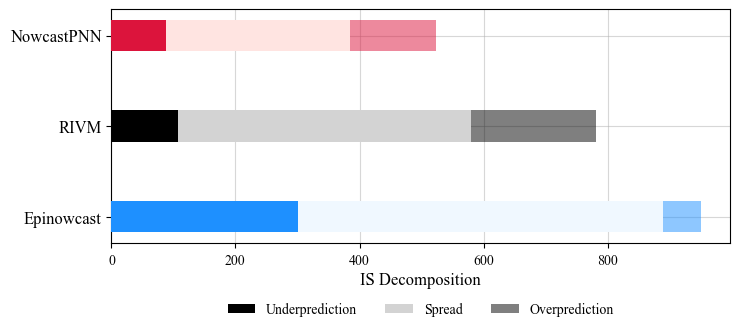

In [54]:
from plotting import plot_is_decomposition, plot_coverages

plot_is_decomposition(epi_scores=epi_is_scores, rivm_scores=rivm_is_scores, pnn_scores=pnn_is_scores)

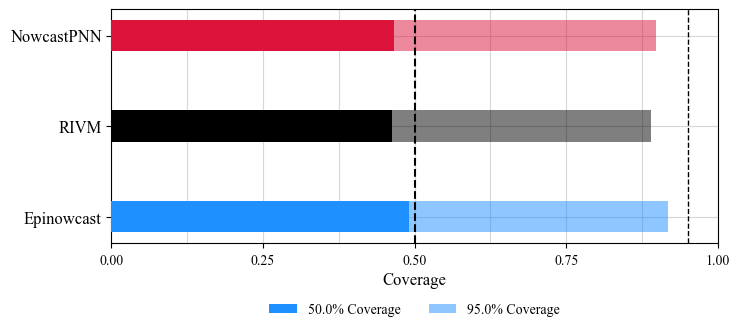

In [53]:
plot_coverages(epi_coverages=epi_coverages, rivm_coverages=rivm_coverages, pnn_coverages=pnn_coverages)